In [1]:
import numpy as np

import matplotlib.pyplot as plt

from neurodsp.sim import sim_oscillation
from neurodsp.spectral import compute_spectrum

from timescales.sim import sim_ou
from timescales.fit import PSD
from timescales.conversions import convert_knee
from timescales.autoreg import compute_ar_spectrum
from timescales.plts import set_default_rc
set_default_rc()

# 02. PSD Objects

This tutorials explores the use of the PSD objects.

In [2]:
# Settings
n_seconds = 20
fs = 1000
knee_freq = 10
tau = convert_knee(knee_freq)
ar_order = 50

# Simulate a signal
np.random.seed(0)
sig = sim_ou(n_seconds, fs, tau, mu=0, std=1)
sig += sim_oscillation(n_seconds, fs, knee_freq)

### Compute Spectra
PSD objects have a compute_spectrum method that may be called from an empty intialization. This method supports neurodsp's compute_spectrum and timescale's compute_ar_spectrum functions. Alternatively, external functions that compute spectra may be used, and these arrays may be specificed when initalizing a PSD object. Once the freqs and powers attributes have been defined, the model may be fit.

In [3]:
# Compute spectrum using method
psd = PSD()
psd.compute_spectrum(sig, fs, ar_order)

# Or using an external function
psd = PSD()
freqs, powers = compute_spectrum(sig, fs)
psd = PSD(freqs, powers)

### Fitting: 1d

PSD objects support FOOOF models or any loss function supported by scipy.optimize.least_squares. If a loss function is specified, a single call to scipy's curve fit is used to optimize the aperiodic Lorentzian model. Loss functions are preferred when a large amount of spectra need to be processed and when oscillations are not dominate. 

In [4]:
%%timeit

psd.fit(method='fooof', fooof_init={'peak_threshold': 2.5})

389 ms ± 65.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%%timeit

psd.fit(method='huber')

12.4 ms ± 130 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


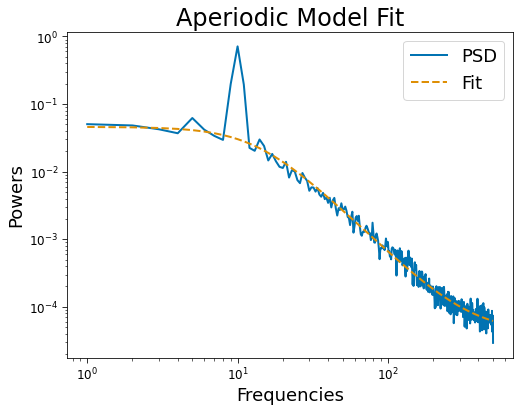

In [6]:
psd.plot()

### Fitting: 2d

2d arrays of signals or powers are supported.

In [7]:
# Simulate signals
fs = 1000
n_seconds = 5

nsigs = 20

sigs = np.zeros((nsigs, int(n_seconds * fs)))

for ind in range(nsigs):
    np.random.seed(ind)
    sigs[ind] = sim_ou(n_seconds, fs, tau, mu=0, std=1)
    sigs[ind] += sim_oscillation(n_seconds, fs, knee_freq)

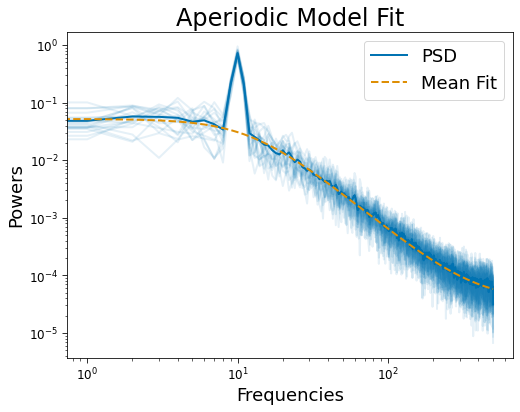

In [8]:
# Fit
psd = PSD()
psd.compute_spectrum(sigs, fs, n_jobs=-1)
psd.fit()
psd.plot()

### Results

Optimized parameters, labels, and model r-squared values are stored as attributes.

In [9]:
psd.param_names

['offset', 'knee_freq', 'exp', 'const']

In [10]:
psd.params[:5]

array([[1.21103820e+00, 1.58865485e+01, 2.22213869e+00, 4.26877247e-05],
       [1.11018870e+00, 1.26717317e+01, 2.14993387e+00, 3.72941433e-05],
       [8.10003073e-01, 8.90468822e+00, 1.99168729e+00, 3.04245194e-05],
       [1.14814023e+00, 1.37547579e+01, 2.18871576e+00, 4.36597018e-05],
       [6.83293436e-01, 9.57179775e+00, 1.95570067e+00, 2.82382679e-05]])

In [11]:
psd.rsq[:5]

array([0.91342092, 0.91370156, 0.91873742, 0.91313481, 0.915072  ])